# [TODO] Figure out why the error doesn't decrease along the grid spacing

# [TODO] Compare the analytical solution of trajectory for gaussian case

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
delta_t = 0.05
t0 = 0.0
N_t = 5
N_timestep = N_t - 1
t_arr = t0 + delta_t * np.arange(N_t)
k0 = 0.1
x_arr = np.linspace(-2,2,21)
x_p_arr = np.array([0.0, 0.31, 0.6])
N_p = x_p_arr.size

def get_psi(x, t):
    return np.exp(1.0j * (k0 * x - 0.5*k0*k0*t))

In [3]:
class system(object):
    def __init__(self, t0, x_arr, sf_arr_t0):
        self.t = t0
        self.x_arr = x_arr
        self.sf_arr = sf_arr_t0
    
    def propagate(self, delta_t):
        self.t += delta_t
        self.sf_arr = get_psi(self.x_arr, self.t)

In [4]:
from tdse.finite_difference import eval_deriv_on_equidistanced_grid

def prop_xx(xx_t, delta_t, x_arr, sf_arr_next, log=False, g_zero_thres=1e-11, xx_diff_thres=1e-13):
    
    _xx_t_k = xx_t

    while True:

        _psi, _dpsi, _ddpsi = eval_deriv_on_equidistanced_grid(
            np.array([xx_t]), x_arr, sf_arr_next, orders=[0,1,2], N_s=4)[:,0]
        _g_k = xx_t - _xx_t_k + delta_t * (_dpsi / _psi).imag
        if log: print("xx_t_k: {:.16f} / g_k: {:.16f}".format(_xx_t_k, _g_k))

        if np.abs(_g_k) < g_zero_thres: break

        _psi_sq = (_psi.conj() * _psi).real
        _xx_t_k_next = _xx_t_k - ( (xx_t - _xx_t_k)*_psi_sq + delta_t * (_psi.conj()*_dpsi).imag ) \
            / ( delta_t * (_psi.conj()*_ddpsi - _psi.conj() / _psi * (_dpsi*_dpsi)).imag - 1.0 )
        assert np.abs(_xx_t_k_next - _xx_t_k) > xx_diff_thres
        _xx_t_k = _xx_t_k_next
    
    _xx_t_next = _xx_t_k
    
    return _xx_t_next

# Propagation

In [5]:
sys = system(t0, x_arr, get_psi(x_arr,t0))

x_p_t_arr = np.empty((N_t, x_p_arr.size), dtype=float)
x_p_t_arr[0,:] = x_p_arr

for _t_idx in range(N_timestep):
    
    sys.propagate(delta_t)
    
    for _i_p in range(x_p_arr.size):
        x_p_arr[_i_p] = prop_xx(x_p_arr[_i_p], delta_t, x_arr, sys.sf_arr, log=False)
        
    x_p_t_arr[_t_idx+1,:] = x_p_arr[:]

# Visualizing trajectories

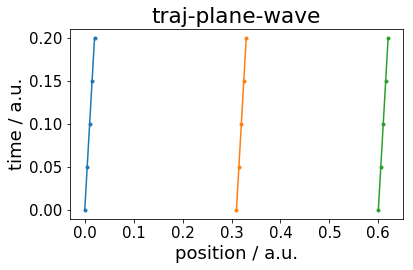

In [6]:
rcParams['font.size'] = 15

fig, ax = plt.subplots()

for _i_p in range(N_p):
    ax.plot(x_p_t_arr[:,_i_p], t_arr, '.-')

ax.set_ylabel("time / a.u.")
ax.set_xlabel("position / a.u.")
ax.set_title("traj-{:s}".format("plane-wave"))

fig.tight_layout()
fig.savefig(ax.get_title())